# Big Mart Sale Forecast

## Importing Necessary Modules/Libraries

In [49]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

## Loading the Dataset

In [27]:
df = pd.read_csv('train.csv')

In [28]:
df

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.300,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.920,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.500,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.200,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.930,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052
...,...,...,...,...,...,...,...,...,...,...,...,...
8517,FDF53,20.750,reg,0.083607,Frozen Foods,178.8318,OUT046,1997,Small,Tier 1,Supermarket Type1,3608.6360
8518,FDF22,6.865,Low Fat,0.056783,Snack Foods,214.5218,OUT013,1987,High,Tier 3,Supermarket Type1,2778.3834
8519,FDS36,8.380,Regular,0.046982,Baking Goods,108.1570,OUT045,2002,NaN,Tier 2,Supermarket Type1,549.2850
8520,NCJ29,10.600,Low Fat,0.035186,Health and Hygiene,85.1224,OUT035,2004,Small,Tier 2,Supermarket Type1,1193.1136


## Investigating the Dataframe

In [29]:
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,7059.000000,8522.000000,8522.000000,8522.000000,8522.000000
mean,12.857370,0.066135,141.000471,1997.831964,2181.455027
std,4.643728,0.051600,62.274675,8.372247,1706.530835
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,8.772500,0.026988,93.844250,1987.000000,834.913200
50%,12.600000,0.053935,143.014100,1999.000000,1794.331000
75%,16.850000,0.094594,185.652250,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8522 entries, 0 to 8521
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8522 non-null   object 
 1   Item_Weight                7059 non-null   float64
 2   Item_Fat_Content           8522 non-null   object 
 3   Item_Visibility            8522 non-null   float64
 4   Item_Type                  8522 non-null   object 
 5   Item_MRP                   8522 non-null   float64
 6   Outlet_Identifier          8522 non-null   object 
 7   Outlet_Establishment_Year  8522 non-null   int64  
 8   Outlet_Size                6112 non-null   object 
 9   Outlet_Location_Type       8522 non-null   object 
 10  Outlet_Type                8522 non-null   object 
 11  Item_Outlet_Sales          8522 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.1+ KB


In [31]:
df.isnull().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

## Handling the Missing Values

In [32]:
df['Item_Weight'].fillna(df['Item_Weight'].mean(),inplace=True)

In [33]:
df.isnull().sum()

Item_Identifier                 0
Item_Weight                     0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [34]:
mode = df.pivot_table(values='Outlet_Size',columns='Outlet_Type',aggfunc=lambda x : x.mode()[0])

In [35]:
mode

Outlet_Type,Grocery Store,Supermarket Type1,Supermarket Type2,Supermarket Type3
Outlet_Size,Small,Small,Medium,Medium


In [36]:
missing_values = df['Outlet_Size'].isnull()

In [37]:
missing_values.value_counts()

Outlet_Size
False    6112
True     2410
Name: count, dtype: int64

In [38]:
df.loc[missing_values,'Outlet_Size']=df.loc[missing_values,'Outlet_Type'].apply(lambda x : mode[x])

In [39]:
df.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

In [40]:
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000
mean,12.857370,0.066135,141.000471,1997.831964,2181.455027
std,4.226319,0.051600,62.274675,8.372247,1706.530835
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,9.310000,0.026988,93.844250,1987.000000,834.913200
50%,12.857370,0.053935,143.014100,1999.000000,1794.331000
75%,16.000000,0.094594,185.652250,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


## Exploratory Data Analysis

In [41]:
df.columns

Index(['Item_Identifier', 'Item_Weight', 'Item_Fat_Content', 'Item_Visibility',
       'Item_Type', 'Item_MRP', 'Outlet_Identifier',
       'Outlet_Establishment_Year', 'Outlet_Size', 'Outlet_Location_Type',
       'Outlet_Type', 'Item_Outlet_Sales'],
      dtype='object')

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8522 entries, 0 to 8521
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8522 non-null   object 
 1   Item_Weight                8522 non-null   float64
 2   Item_Fat_Content           8522 non-null   object 
 3   Item_Visibility            8522 non-null   float64
 4   Item_Type                  8522 non-null   object 
 5   Item_MRP                   8522 non-null   float64
 6   Outlet_Identifier          8522 non-null   object 
 7   Outlet_Establishment_Year  8522 non-null   int64  
 8   Outlet_Size                8522 non-null   object 
 9   Outlet_Location_Type       8522 non-null   object 
 10  Outlet_Type                8522 non-null   object 
 11  Item_Outlet_Sales          8522 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.1+ KB


In [51]:
numeric_df = df.select_dtypes(include='number')
num_cols=list(numeric_df.columns)
num_cols

['Item_Weight',
 'Item_Visibility',
 'Item_MRP',
 'Outlet_Establishment_Year',
 'Item_Outlet_Sales']

In [52]:
object_df = df.select_dtypes(include='object')
obj_cols=list(object_df.columns)
obj_cols

['Item_Identifier',
 'Item_Fat_Content',
 'Item_Type',
 'Outlet_Identifier',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

### Numeric EDA

#### 1. Summary Statistics

In [53]:
def numeric_summary(df, num_cols):
    return df[num_cols].describe()

In [60]:
numeric_summary(df, num_cols)

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8522.000000,8522.000000,8522.000000,8522.000000,8522.000000
mean,12.857370,0.066135,141.000471,1997.831964,2181.455027
std,4.226319,0.051600,62.274675,8.372247,1706.530835
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,9.310000,0.026988,93.844250,1987.000000,834.913200
50%,12.857370,0.053935,143.014100,1999.000000,1794.331000
75%,16.000000,0.094594,185.652250,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


#### 2. Distribution Plots (Histograms)

In [54]:
def plot_numeric_distributions(df, num_cols):
    for col in num_cols:
        plt.figure(figsize=(6, 4))
        sns.histplot(df[col], kde=True, bins=30)
        plt.title(f'Distribution of {col}')
        plt.show()

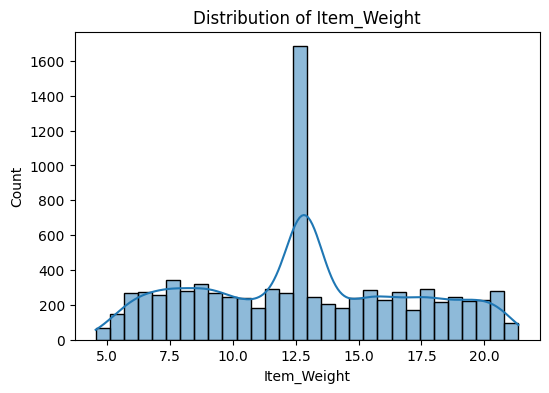

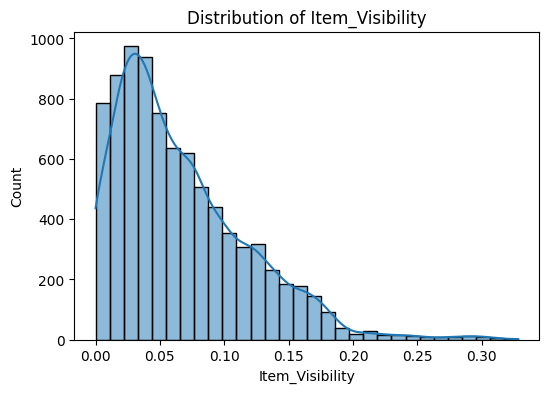

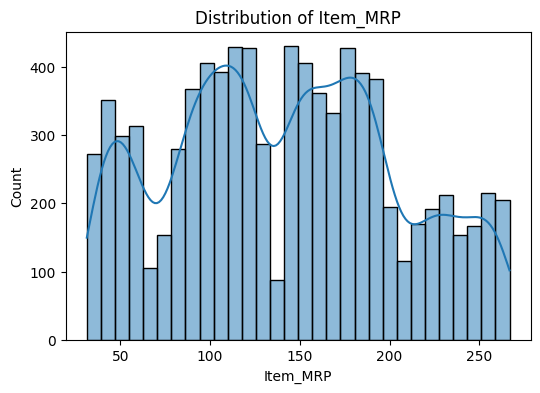

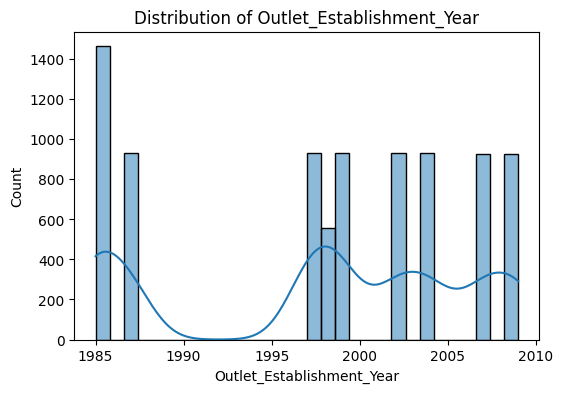

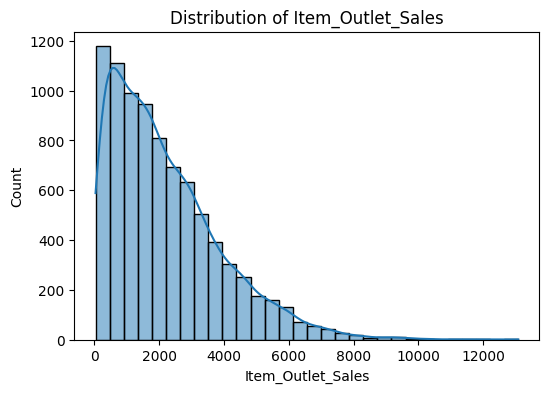

In [61]:
plot_numeric_distributions(df, num_cols)

#### 3. Boxplots for Outliers

In [55]:
def plot_numeric_boxplots(df, num_cols):
    for col in num_cols:
        plt.figure(figsize=(6, 4))
        sns.boxplot(x=df[col])
        plt.title(f'Boxplot of {col}')
        plt.show()

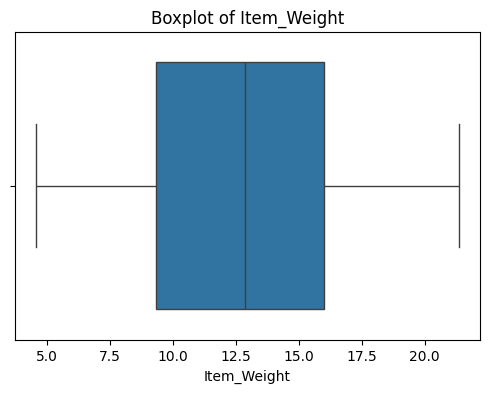

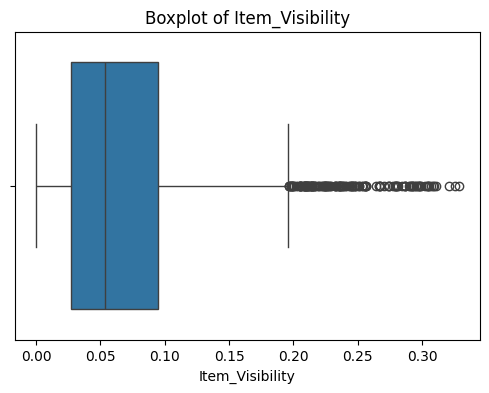

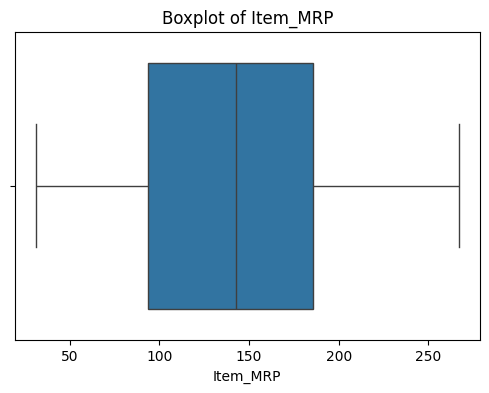

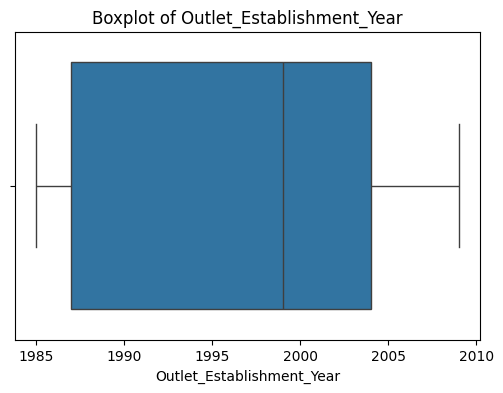

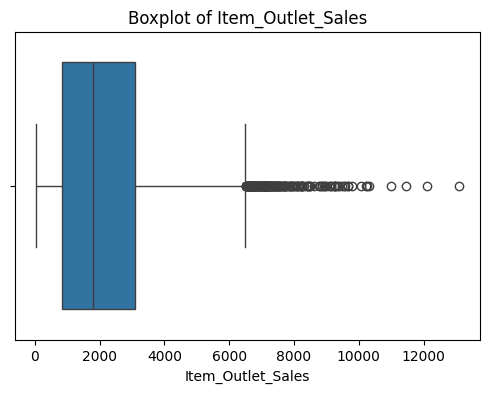

In [62]:
plot_numeric_boxplots(df, num_cols)

#### 4. Correlation Heatmap

In [56]:
def correlation_heatmap(df, num_cols):
    plt.figure(figsize=(8, 6))
    corr = df[num_cols].corr()
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
    plt.title('Correlation Heatmap')
    plt.show()

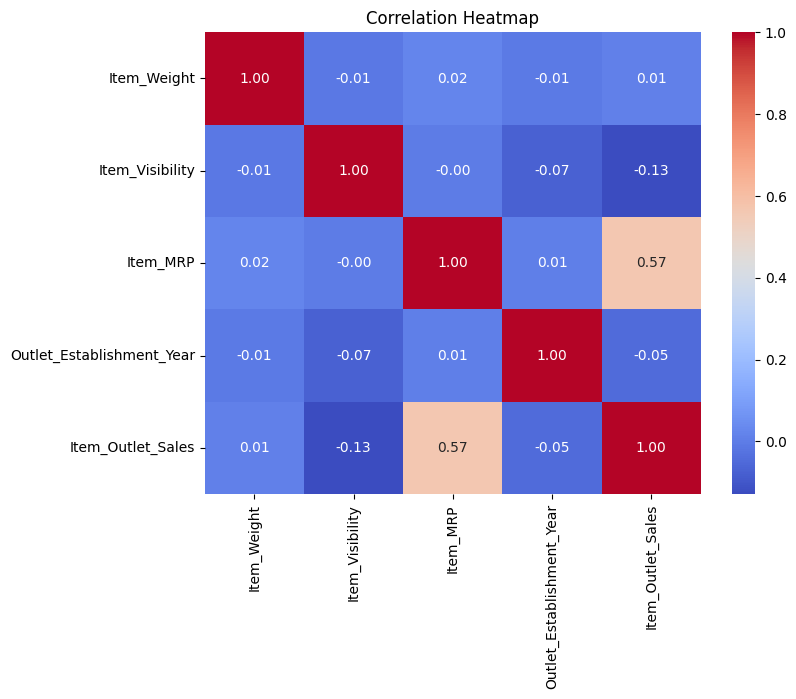

In [63]:
correlation_heatmap(df, num_cols)

### Categorical EDA

#### 1. Value Counts Summary

In [68]:
def categorical_summary_combined(df, obj_cols):
    all_counts = []
    for col in obj_cols:
        vc = df[col].value_counts(dropna=False).reset_index()
        vc.columns = ['Category', 'Count']
        vc['Column'] = col
        all_counts.append(vc)
    return pd.concat(all_counts, ignore_index=True)

In [70]:
combined_summary = categorical_summary_combined(df, obj_cols)
combined_summary

,Category,Count,Column
0,FDW13,10,Item_Identifier
1,FDG33,10,Item_Identifier
2,FDX31,9,Item_Identifier
3,FDT07,9,Item_Identifier
4,NCY18,9,Item_Identifier
...,...,...,...
1595,Tier 1,2387,Outlet_Location_Type
1596,Supermarket Type1,5576,Outlet_Type
1597,Grocery Store,1083,Outlet_Type
1598,Supermarket Type3,935,Outlet_Type


#### 2. Bar Plots

In [89]:
def plot_categorical_counts(df, obj_cols):
    for col in obj_cols:
        if col != 'Item_Identifier':
            plt.figure(figsize=(21, 7))
            sns.countplot(x=df[col], order=df[col].value_counts().index)
            plt.title(f'Count plot of {col}')
            plt.xticks(rotation=45)
            plt.show()

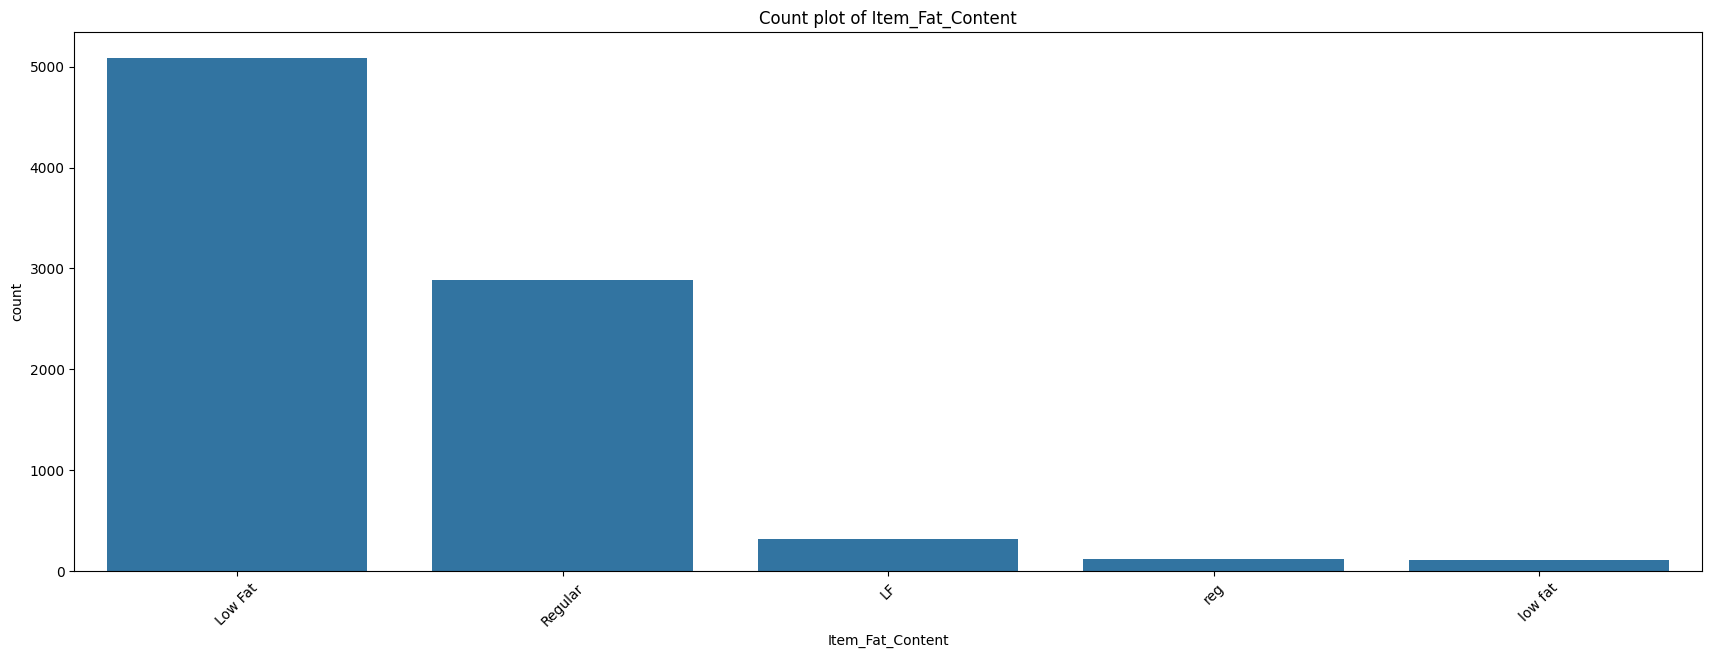

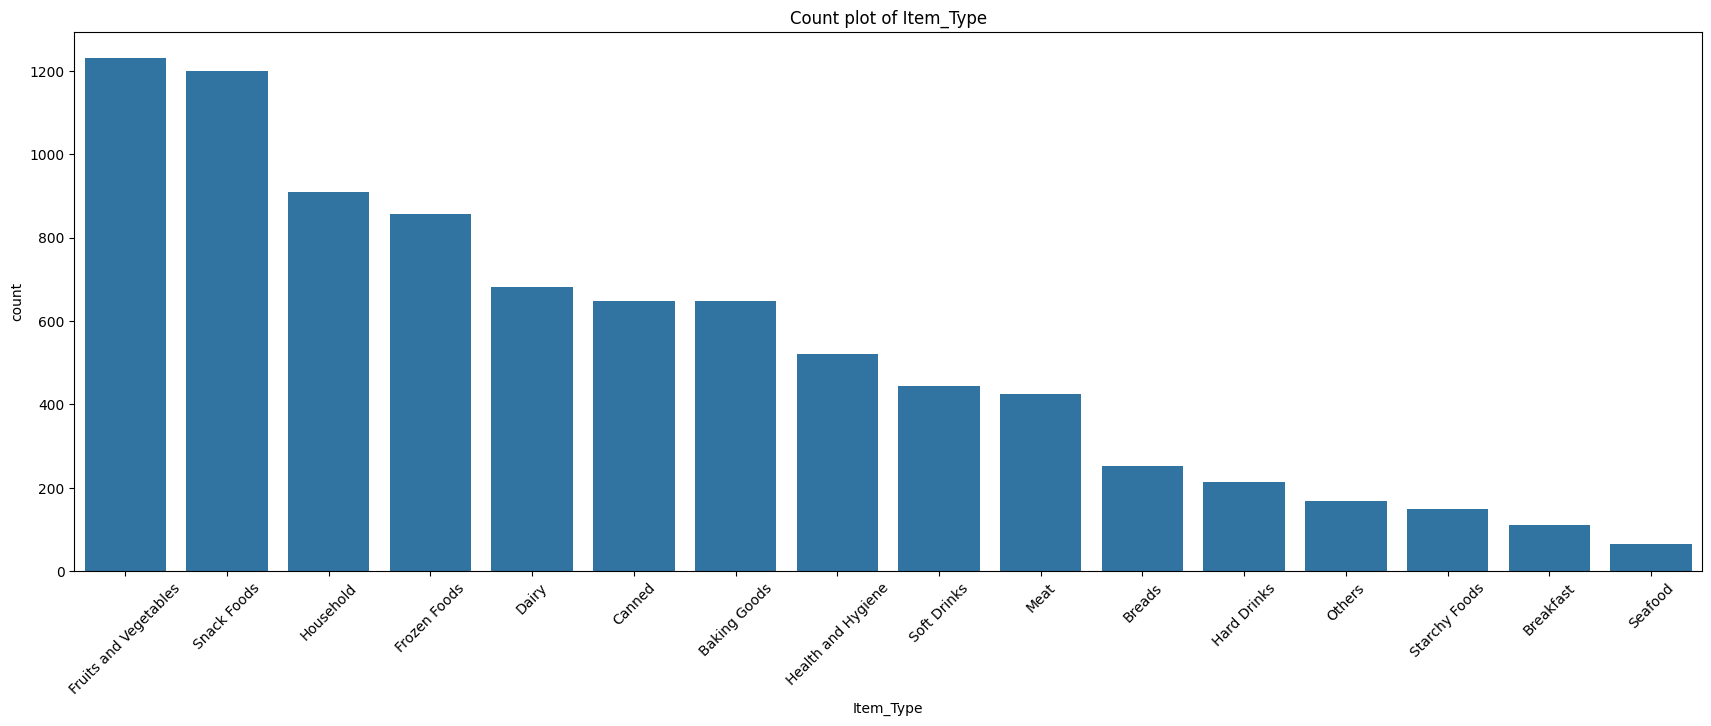

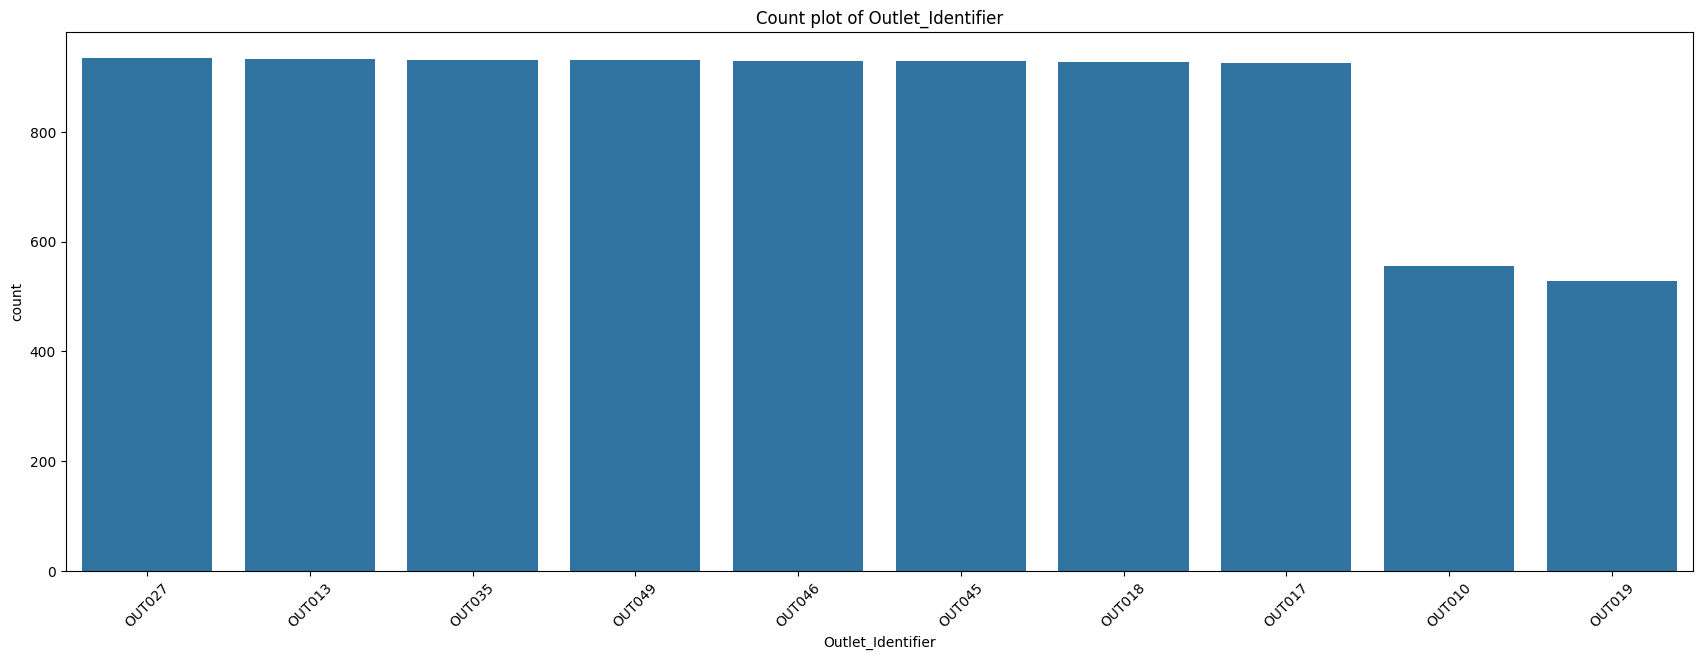

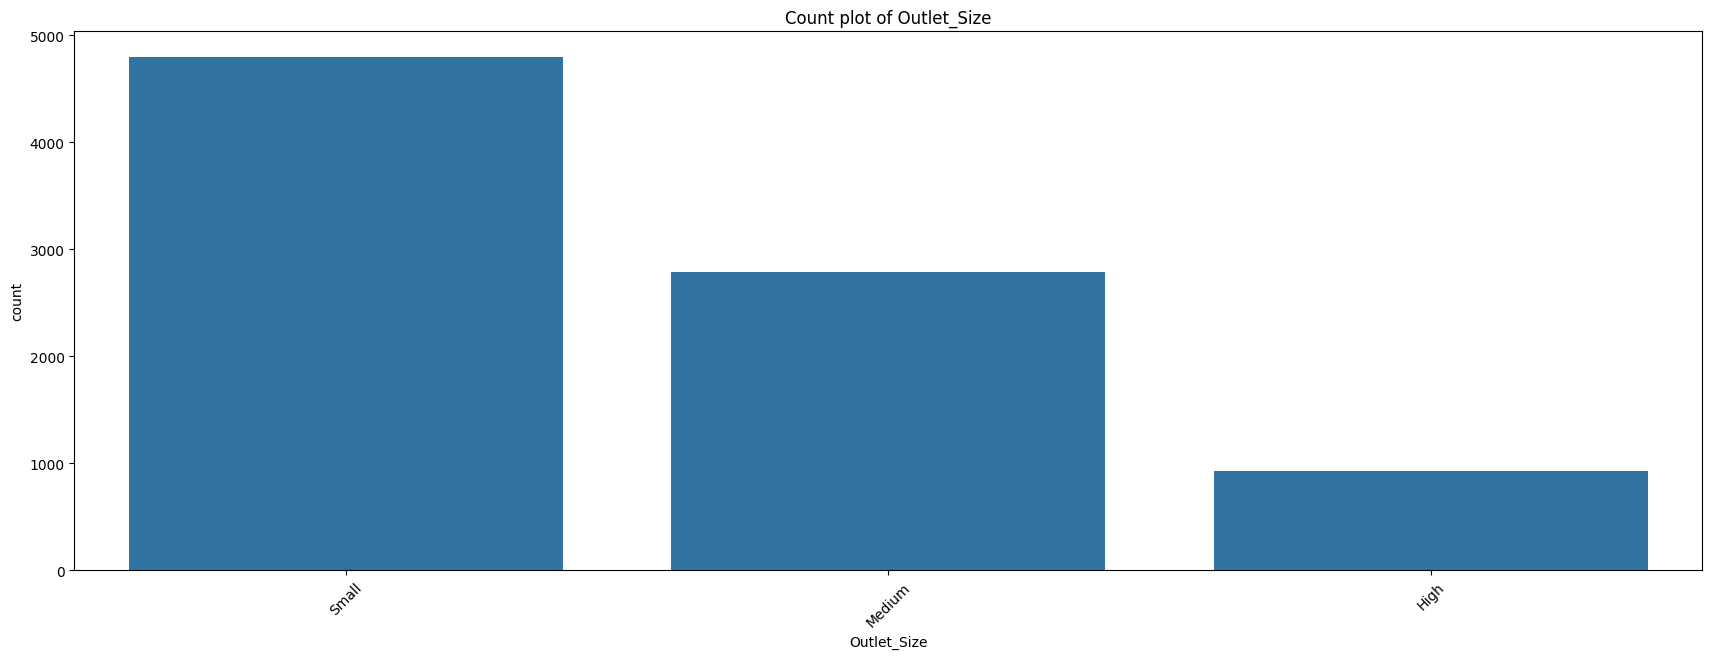

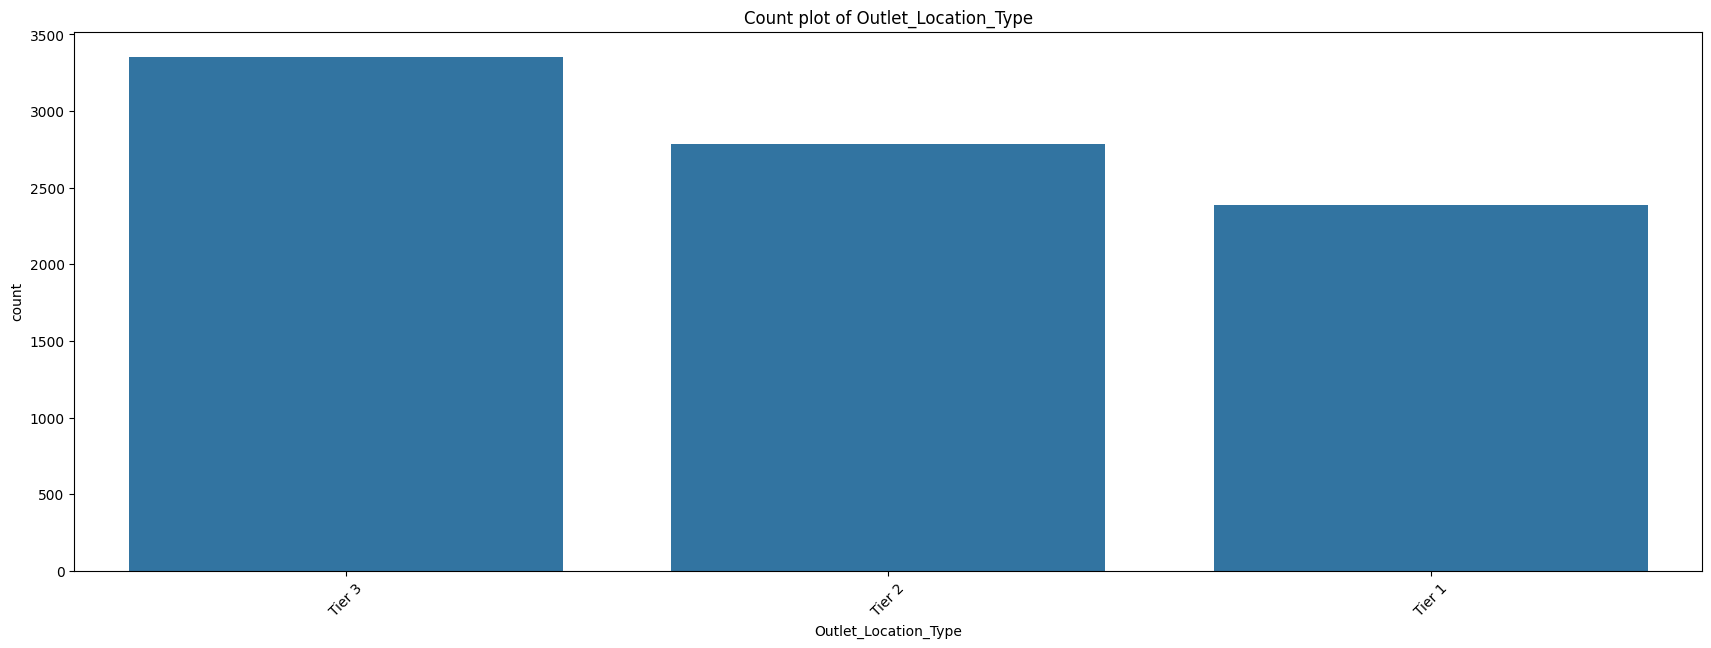

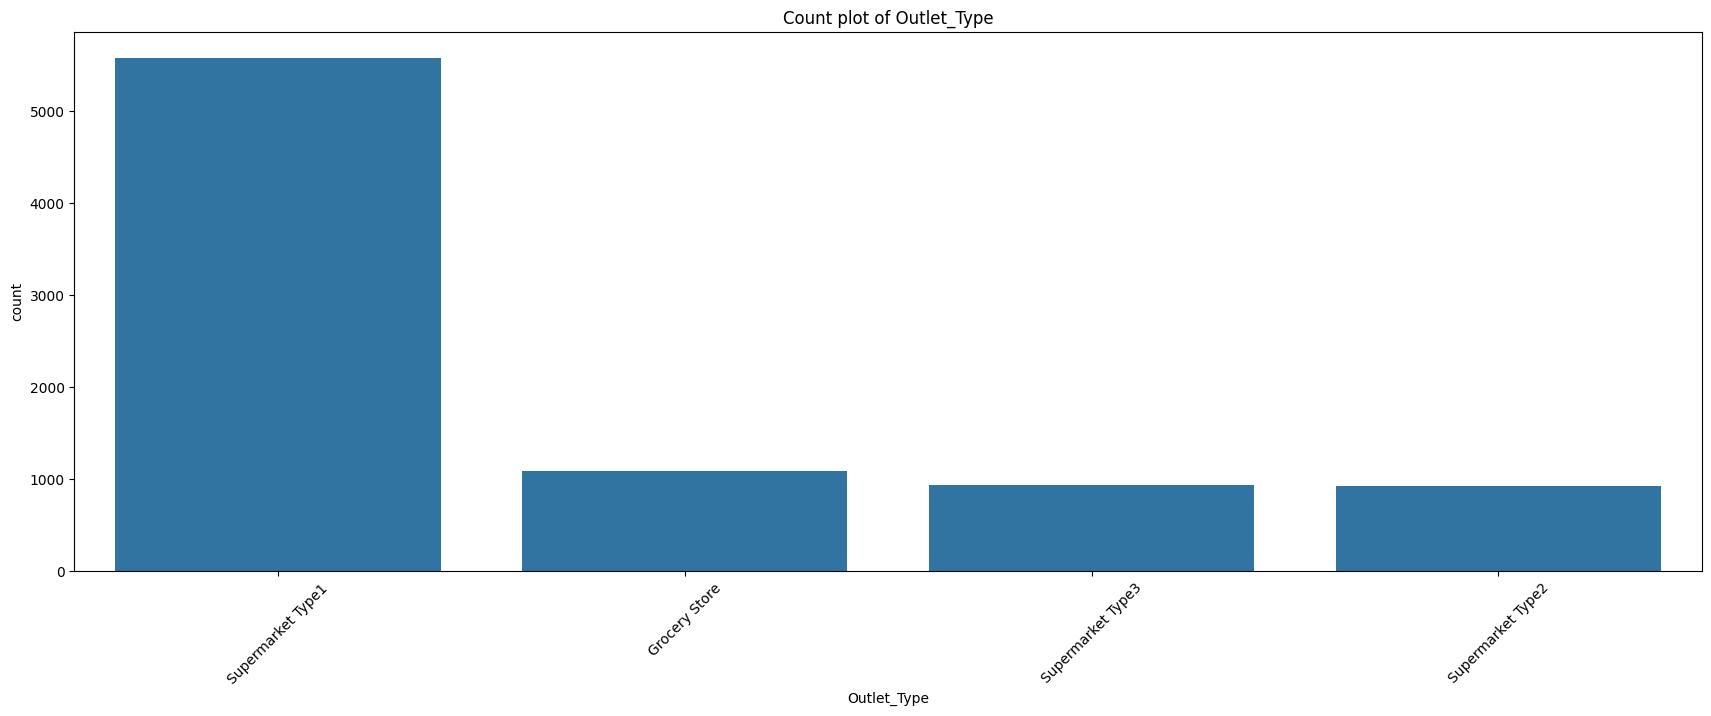

In [90]:
plot_categorical_counts(df, obj_cols)

#### 3. Boxplots of Target by Categorical Variables

In [87]:
def boxplot_target_by_category(df, obj_cols, target):
    for col in obj_cols:
        if col not in 'Item_Identifier':
            plt.figure(figsize=(21, 7))
            sns.boxplot(x=col, y=target, data=df)
            plt.title(f'{target} by {col}')
            plt.xticks(rotation=45)
            plt.show()

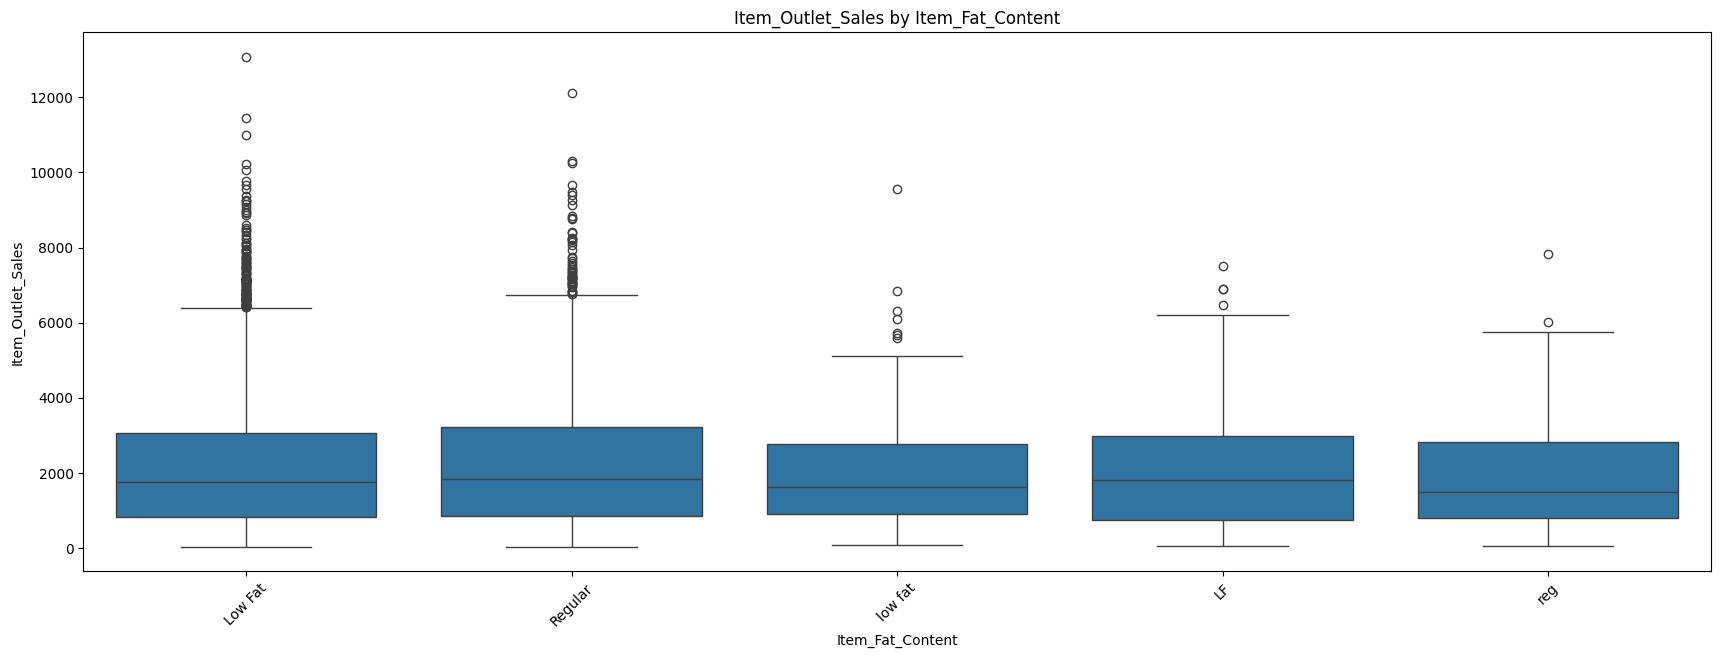

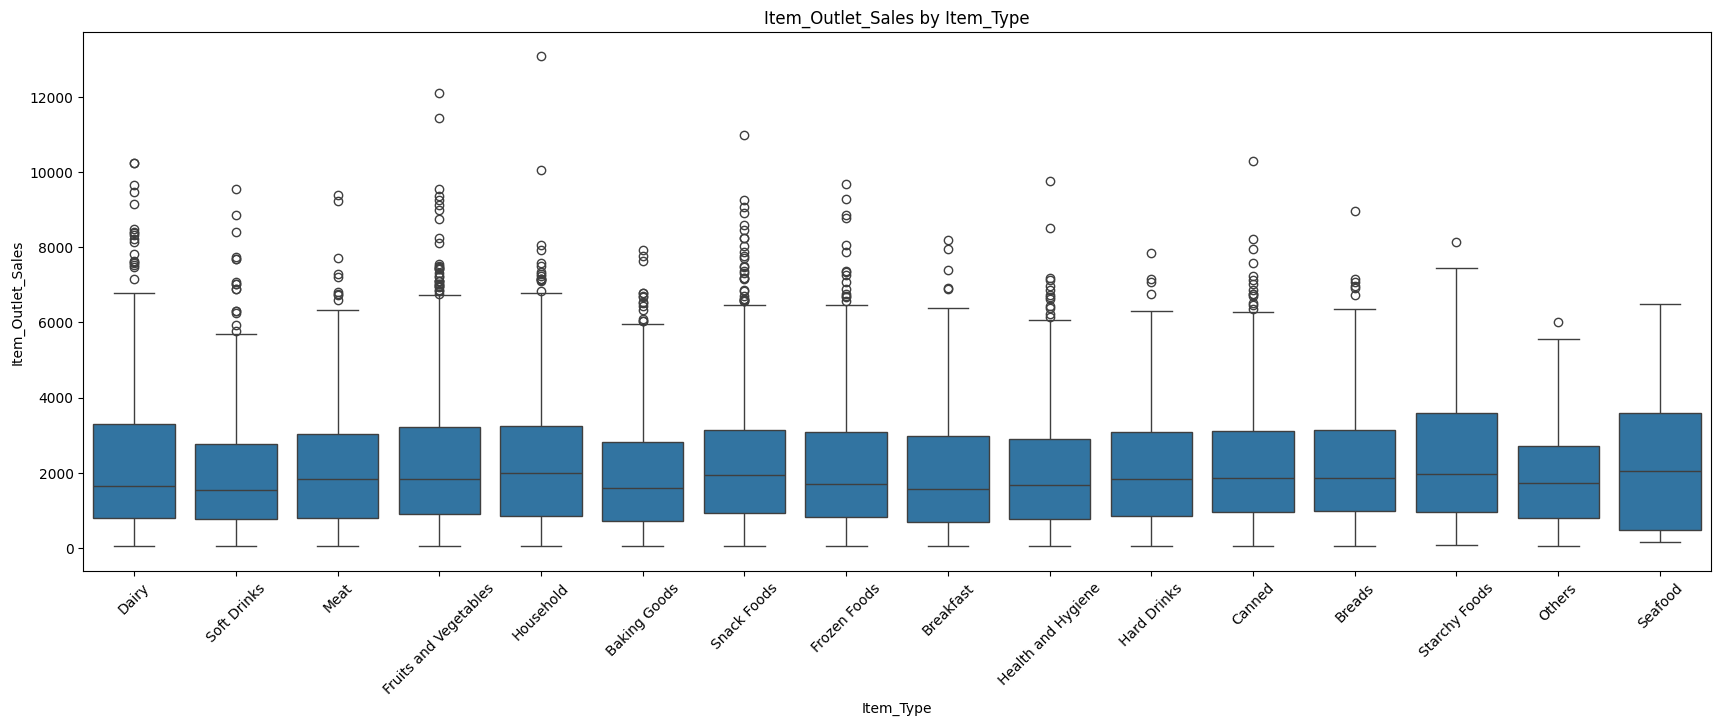

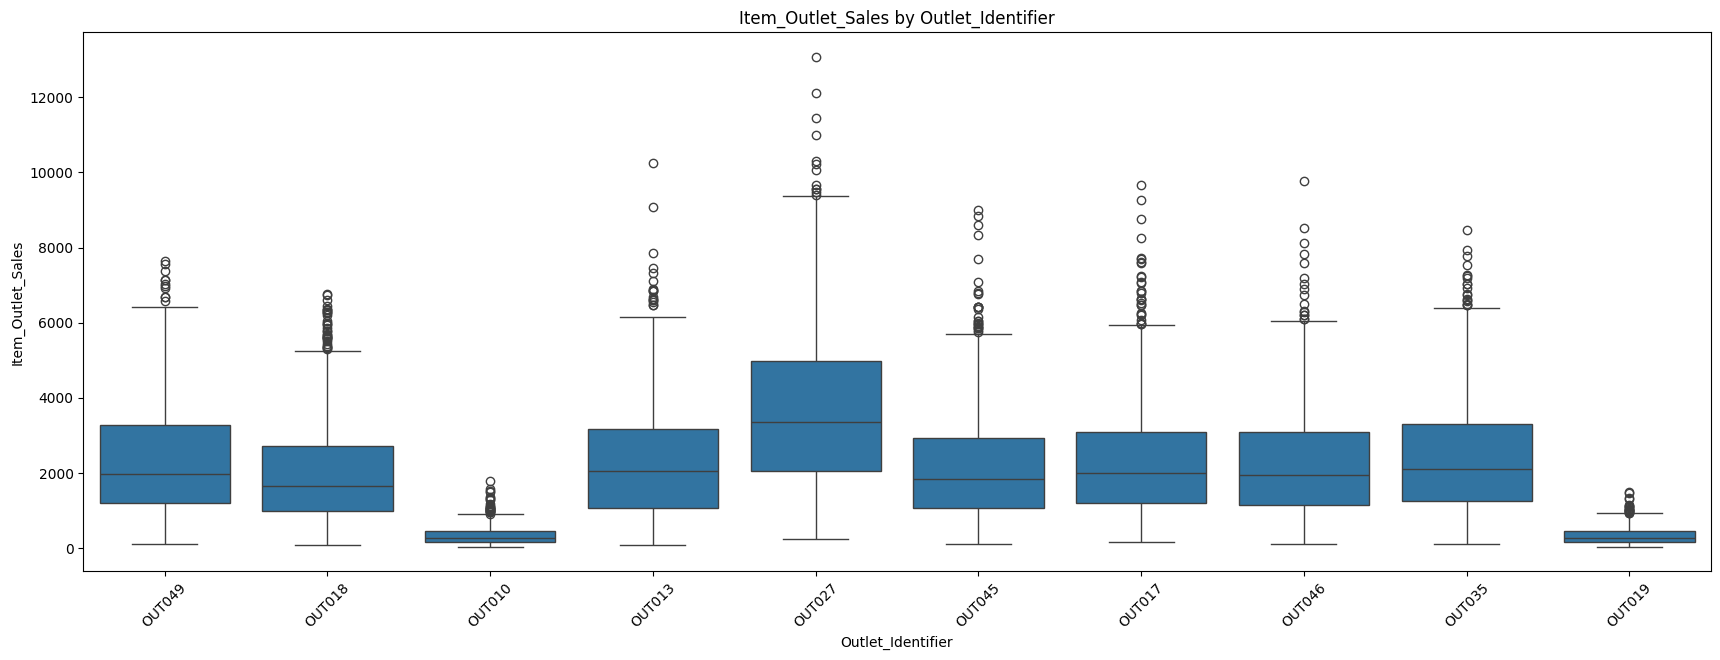

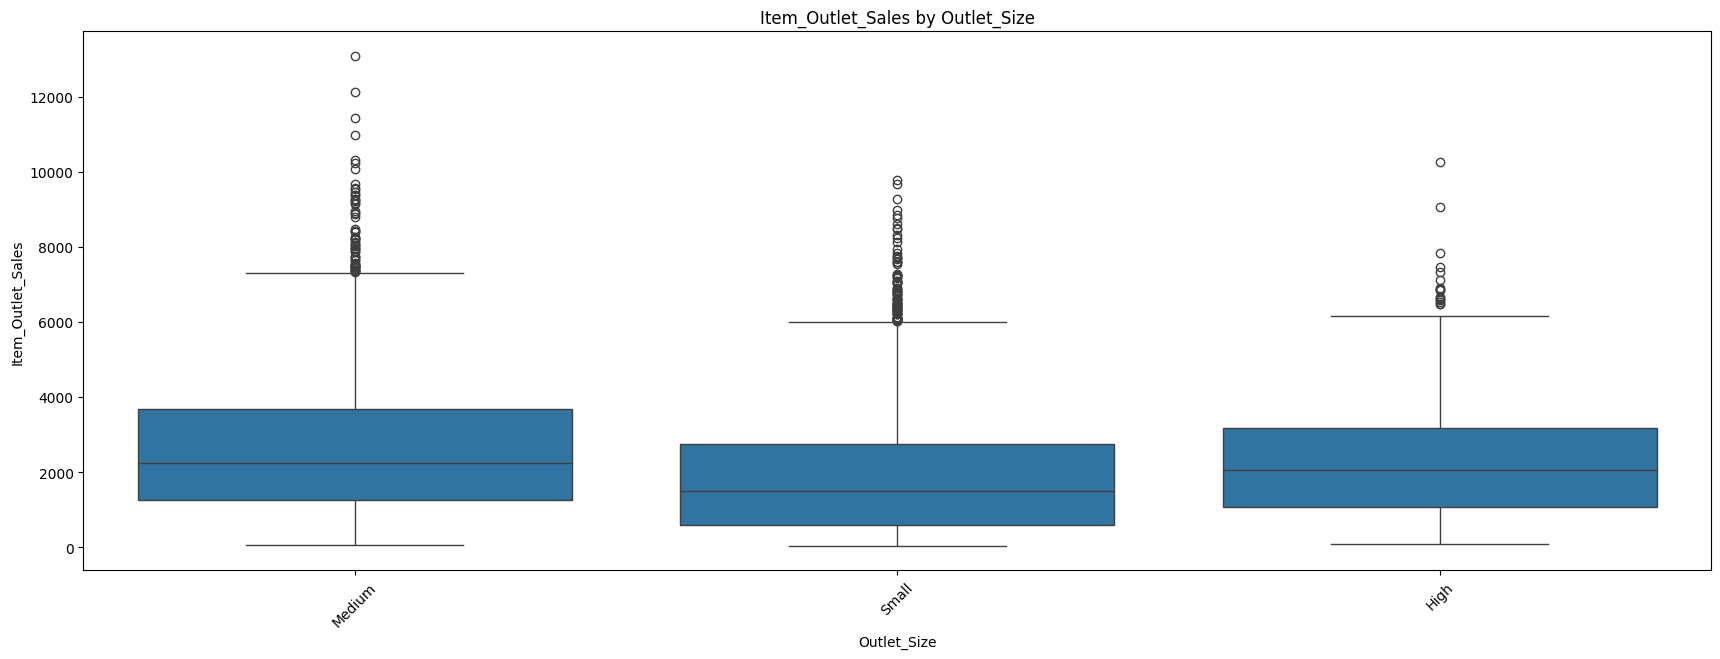

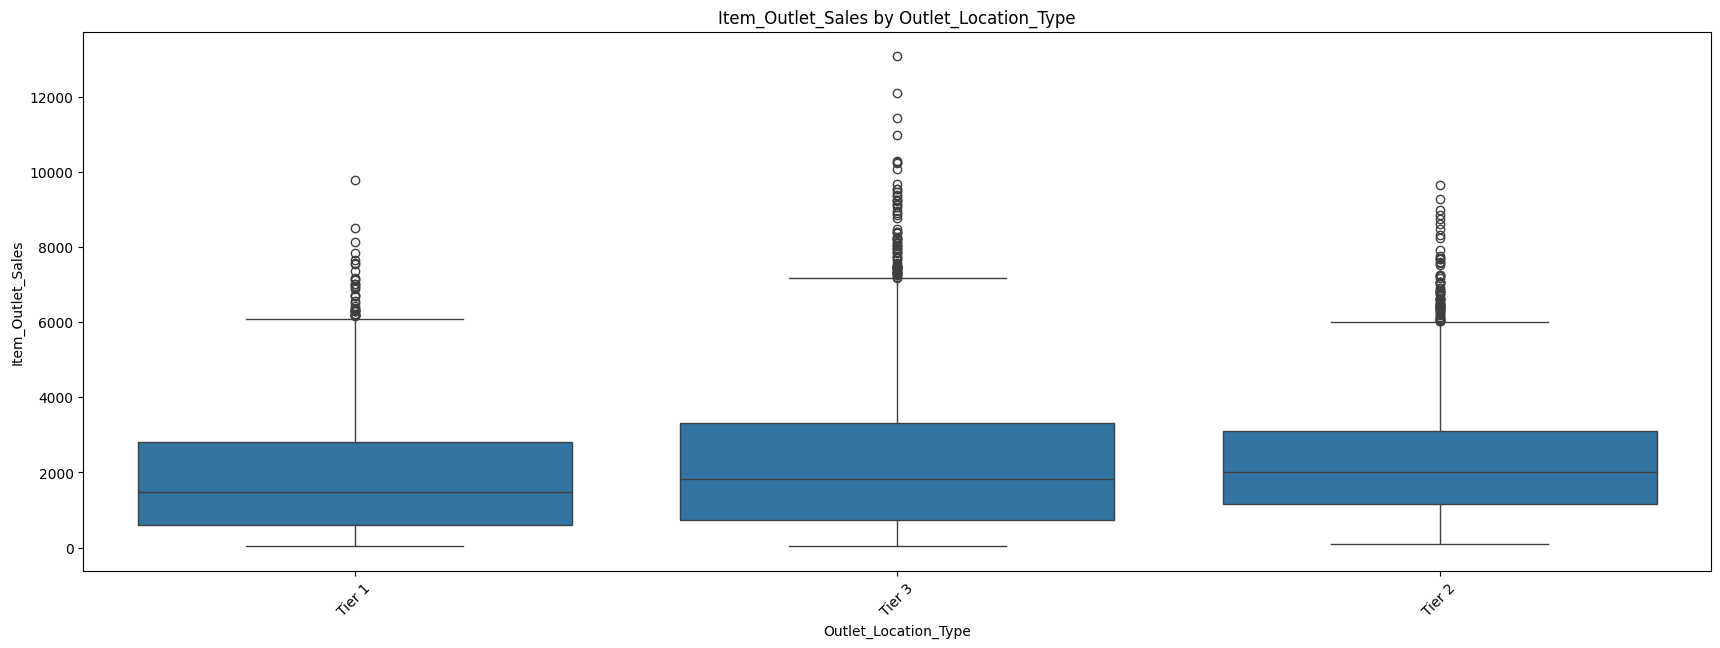

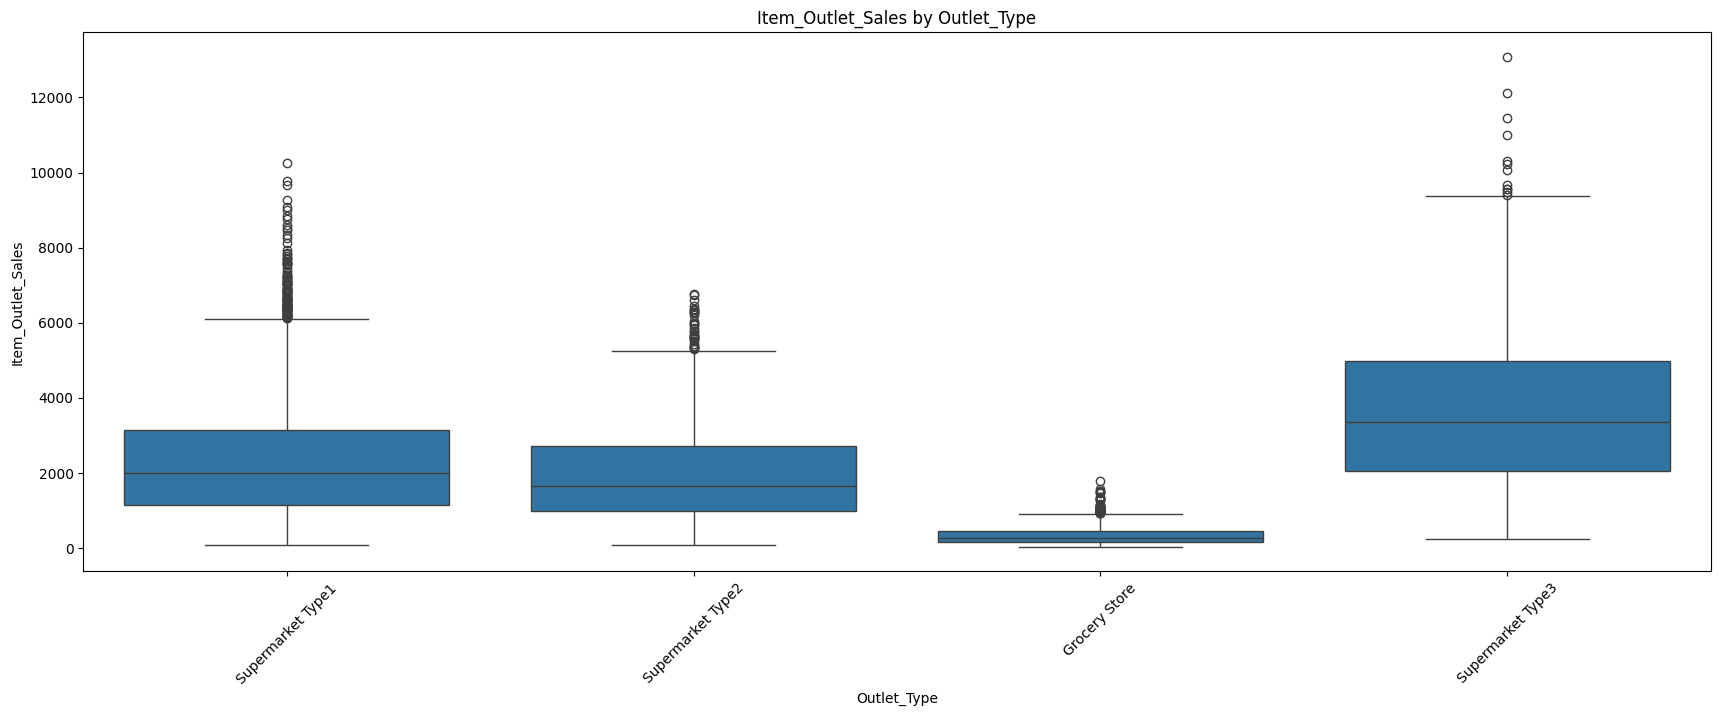

In [88]:
boxplot_target_by_category(df, obj_cols, 'Item_Outlet_Sales')